Table of contents

<h1>Import and preprocessing</h1>

In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

df = pd.read_csv('filtered_property_location_clean.csv', delimiter=';')

#Eine Liste von Spalten zum dropen.
columns_to_drop = ['Canton','longitude','latitude','incometax_municipality','ListingId','LocationId','YearBuilt','Timestamp', 'Availability','AdditionalCost','NetPrice', 'PropertyAdditionalFeaturesId','Vendor', 'street', 'zip','PropertyDescription','bfs_number','municipality',]

#Spalten jetzt dropen.
df= df.drop(columns=columns_to_drop)

<H1>Codierung und Standardisierung der Daten</h1>

In [94]:
# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Apply One-Hot-Encoding to the canton column

df_objectType_encoded = pd.get_dummies(df['ObjectType'])

# Explicitly convert the One-Hot-Encoding columns to int
df_objectType_encoded = df_objectType_encoded.astype(int)

# Concatenate the original DataFrame without the canton column and the result of the One-Hot-Encoding
df = pd.concat([df.drop('ObjectType', axis=1), df_objectType_encoded], axis=1)

if 'Floor' in df.columns:
    df['Floor'] = df['Floor'].replace('EG', 0)
    df['Floor'] = pd.to_numeric(df['Floor'], errors='coerce')
    # Entfernen der Zeilen, in denen 'Floor' NaN ist
    data = df.dropna(subset=['Floor'])
    # Filtere die Zeilen, bei denen 'Floor' kleiner oder gleich 10 ist
    # Zähle die Anzahl der entfernten Zeilen
    rows_removed = data[data['Floor'] > 10]
    rows_removed_count = rows_removed.shape[0]

    # Zeige die Anzahl der entfernten Zeilen an
    print(f'Anzahl der entfernten Zeilen: {rows_removed_count}')

    
# Lösche die Daten mit NaN-Werten in der Spalte 'population_density'
df = df.dropna(subset=['population_density','Floor'])

Anzahl der entfernten Zeilen: 149


<h1>Split data and train </h1>

In [95]:
# X(Unabhängige Variablen) and y(Ziel variables)
X = df.drop(columns=['Price', 'Price_per_m2'])
y = df['Price'].values

# Das Splitten der Daten zwischen Training-und Testdaten
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)


<h1>Multiple Linear Regression</h1>

In [96]:
# Speichere die Spaltennamen
feature_names = X.columns

# Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_score = mlr.score(X_test, y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(y_test, pred_mlr)


# Extrahiere die Koeffizienten des Modells
coefficients = mlr.coef_

# Erstelle einen DataFrame für die Feature-Koeffizienten
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sortiere die Features nach dem absoluten Wert der Koeffizienten und wähle die Top 10 aus
top_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)



<h1>Decision Tree Regressor</h1>

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.2s
Beste Parameter für DecisionTree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Erklärte Varianz des besten DecisionTree-Modells: 0.5969355017516049


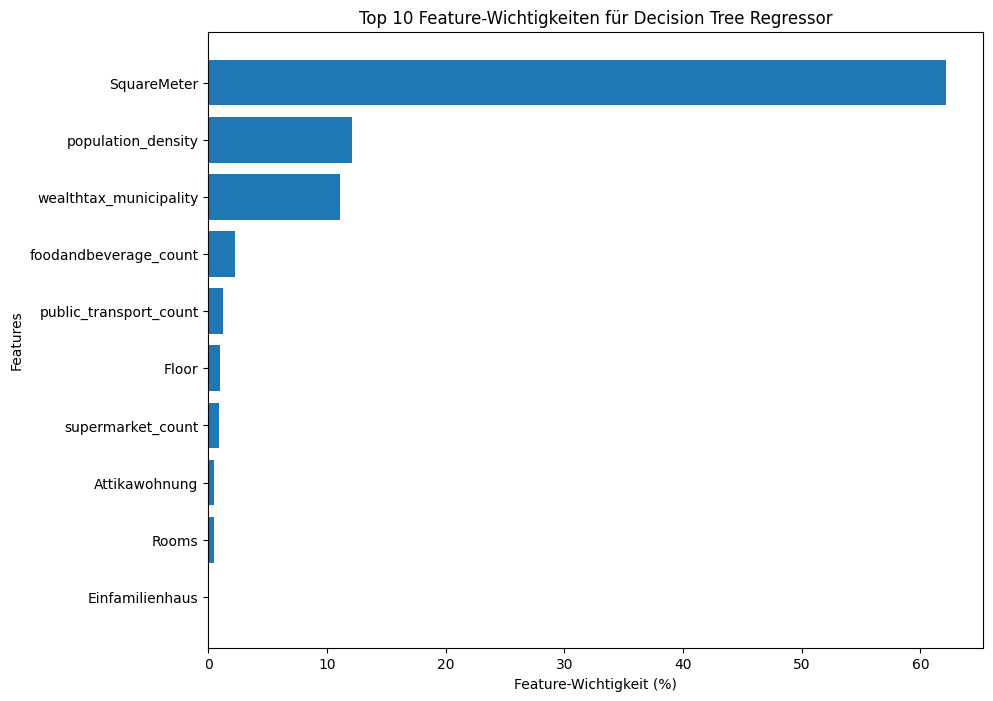

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definiere die zu optimierenden Hyperparameter
dt_param_grid = {
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Erstelle das Decision Tree Regressor-Objekt
dt_regressor = DecisionTreeRegressor(random_state=0)

# Setze GridSearchCV auf
dt_grid_search = GridSearchCV(estimator=dt_regressor, param_grid=dt_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Trainiere das Modell
dt_grid_search.fit(X_train, y_train)
dt_best_model = dt_grid_search.best_estimator_
print(f"Beste Parameter für DecisionTree: {dt_grid_search.best_params_}")

# Evaluierung des besten Modells
dt_best_pred = dt_best_model.predict(X_test)
dt_best_score = explained_variance_score(y_test, dt_best_pred)
print(f"Erklärte Varianz des besten DecisionTree-Modells: {dt_best_score}")

# Feature-Wichtigkeiten für DecisionTreeRegressor
dt_importances = dt_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
})

# Aggregiere kantonbezogene Features
canton_features = feature_importance_df[feature_importance_df['Feature'].str.contains('canton', case=False)]
canton_importance = canton_features['Importance'].sum()

# Entferne kantonbezogene Features aus dem ursprünglichen DataFrame und füge die aggregierte Wichtigkeit hinzu
non_canton_features = feature_importance_df[~feature_importance_df['Feature'].str.contains('canton', case=False)]
aggregated_features = pd.concat([non_canton_features, pd.DataFrame({'Feature': ['All Cantons'], 'Importance': [canton_importance]})], ignore_index=True)

# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus, ohne "All Cantons"
top_features = aggregated_features[aggregated_features['Feature'] != 'All Cantons'].sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
top_features['Importance'] = top_features['Importance'] * 100

# Plot der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature-Wichtigkeit (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature-Wichtigkeiten für Decision Tree Regressor")
plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R² für das Decision Tree-Modell
mse_best_dt = mean_squared_error(y_test, dt_best_pred)
rmse_best_dt = np.sqrt(mse_best_dt)
mae_best_dt = mean_absolute_error(y_test, dt_best_pred)
r2_best_dt = r2_score(y_test, dt_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
dtr_score = round(dt_best_model.score(X_test, y_test) * 100)


<h1>Random Forest Regressor</h1>

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
Beste Parameter für RandomForest: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Erklärte Varianz des besten RandomForest-Modells: 0.6763188941485754


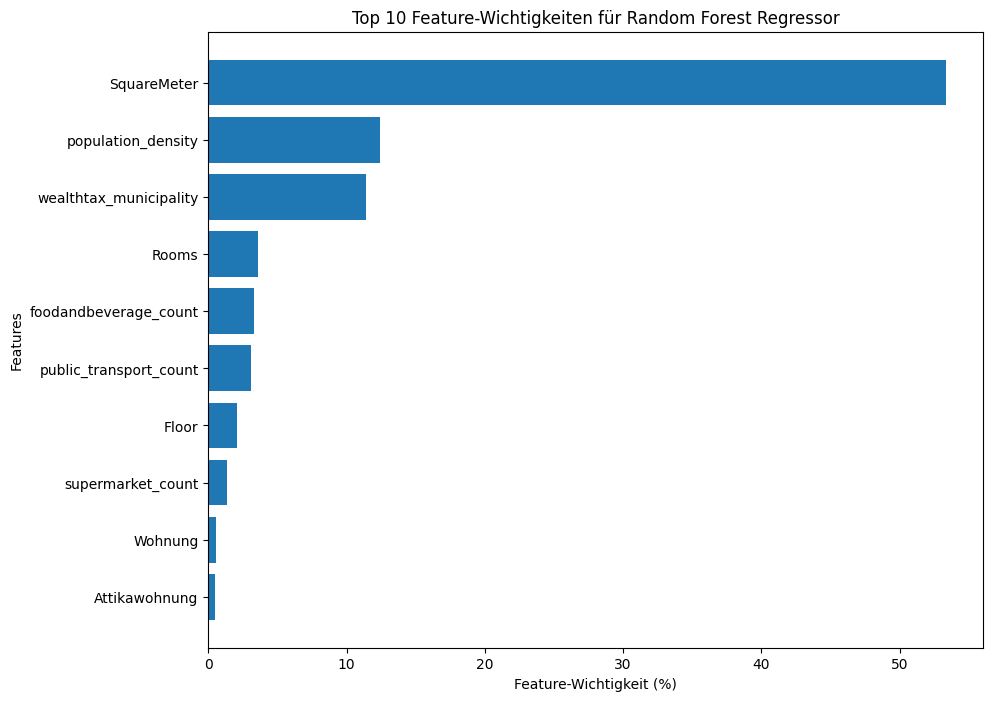

In [98]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definiere die zu optimierenden Hyperparameter
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'bootstrap': [True]
}

# Erstelle das Random Forest Regressor-Objekt
rf_regressor = RandomForestRegressor(random_state=0)

# Setze GridSearchCV auf
rf_grid_search = GridSearchCV(estimator=rf_regressor, param_grid=rf_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Trainiere das Modell
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"Beste Parameter für RandomForest: {rf_grid_search.best_params_}")

# Evaluierung des besten Modells
rf_best_pred = rf_best_model.predict(X_test)
rf_best_score = explained_variance_score(y_test, rf_best_pred)
print(f"Erklärte Varianz des besten RandomForest-Modells: {rf_best_score}")

forest_importances = rf_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': forest_importances
})

# Aggregiere kantonbezogene Features
canton_features = feature_importance_df[feature_importance_df['Feature'].str.contains('canton', case=False)]
canton_importance = canton_features['Importance'].sum()

# Entferne kantonbezogene Features aus dem ursprünglichen DataFrame und füge die aggregierte Wichtigkeit hinzu
non_canton_features = feature_importance_df[~feature_importance_df['Feature'].str.contains('canton', case=False)]
aggregated_features = pd.concat([non_canton_features, pd.DataFrame({'Feature': ['All Cantons'], 'Importance': [canton_importance]})], ignore_index=True)

# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus, ohne "All Cantons"
top_features = aggregated_features[aggregated_features['Feature'] != 'All Cantons'].sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
top_features['Importance'] = top_features['Importance'] * 100

# Plot der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature-Wichtigkeit (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature-Wichtigkeiten für Random Forest Regressor")
plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R²
mse_best_rf = mean_squared_error(y_test, rf_best_pred)
rmse_best_rf = np.sqrt(mse_best_rf)
mae_best_rf = mean_absolute_error(y_test, rf_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)


<h1>XGBOOST</h1>

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.8s
Beste Parameter für XGBRegressor: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
Erklärte Varianz des besten XGBRegressor-Modells: 0.727643113715635


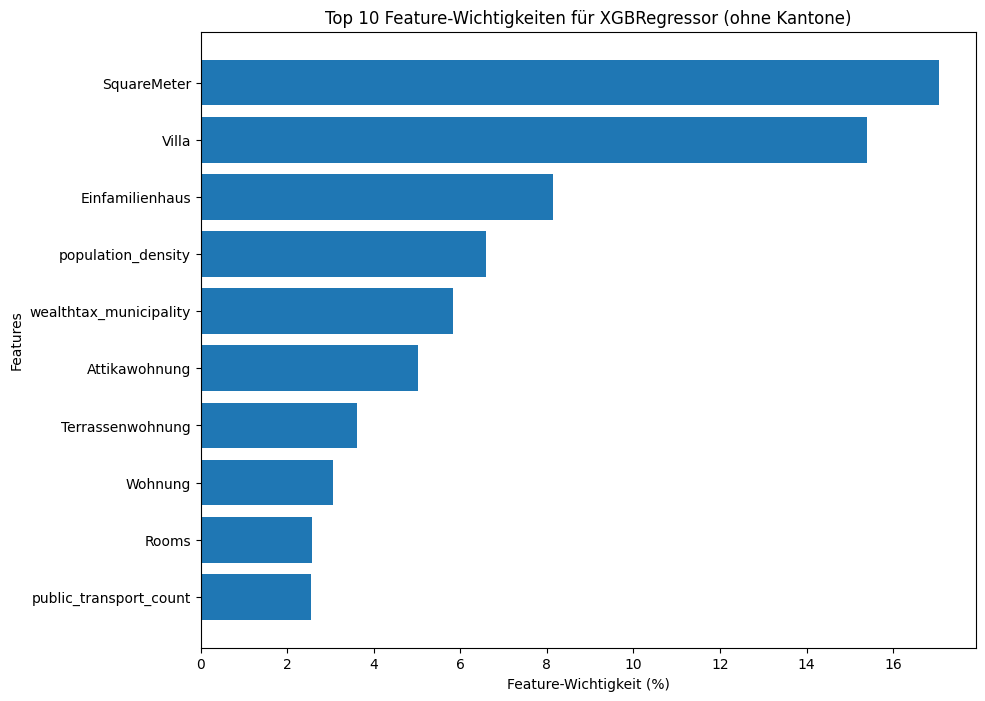

In [99]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definiere die zu optimierenden Hyperparameter
xgb_param_grid = {
    'n_estimators': [200],
    'max_depth': [6],
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.9],
    'gamma': [0]
}

# Erstelle das XGBRegressor-Objekt
xgb_regressor = XGBRegressor(random_state=0)

# Setze GridSearchCV auf
xgb_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=xgb_param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Trainiere das Modell
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Beste Parameter für XGBRegressor: {xgb_grid_search.best_params_}")

# Evaluierung des besten Modells
xgb_best_pred = xgb_best_model.predict(X_test)
xgb_best_score = explained_variance_score(y_test, xgb_best_pred)
print(f"Erklärte Varianz des besten XGBRegressor-Modells: {xgb_best_score}")

# Feature-Wichtigkeiten für XGBRegressor
xgb_importances = xgb_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})

# Entferne kantonbezogene Features aus dem DataFrame
non_canton_features = feature_importance_df[~feature_importance_df['Feature'].str.contains('canton', case=False)]

# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus
top_features = non_canton_features.sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
top_features['Importance'] = top_features['Importance'] * 100

# Plot der Feature-Wichtigkeiten ohne kantonbezogene Features
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature-Wichtigkeit (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature-Wichtigkeiten für XGBRegressor (ohne Kantone)")
plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R² für das XGBoost-Modell
mse_best_xgb = mean_squared_error(y_test, xgb_best_pred)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_xgb = r2_score(y_test, xgb_best_pred)


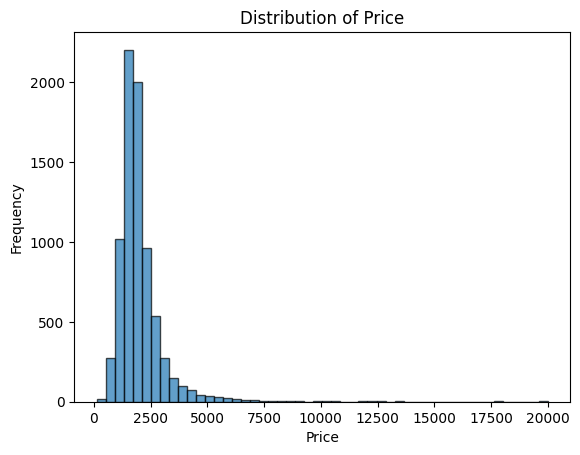

count     7821.000000
mean      2016.723565
std       1119.315866
min        140.000000
25%       1455.000000
50%       1790.000000
75%       2250.000000
max      20000.000000
Name: Price, dtype: float64


In [100]:
import matplotlib.pyplot as plt

# Plot der Verteilung der Zielvariable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Überblick über die statistischen Kennzahlen der Zielvariable
price_stats = df['Price'].describe()
print(price_stats)

Modell bewerten

Schritt 7: Modell verwenden für Vorhersagen

In [101]:
# MeanSquaredError und RootMeanedSquaredErro und MeanAbsolutError,

expl_rf = explained_variance_score(y_test, rf_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)

# MeanSquaredError und RootMeanedSquaredErro und MeanAbsolutError, RScored.
print("Multiple Linear Regression Model Score is ",round(mlr.score(X_test,y_test)*100))
print("Decision tree  Regression Model Score is ",round(dtr_score))
print("Random Forest Regression Model Score is ",round(r2_best_rf * 100))
print("XGBoost Regression Model Score is ", round(xgb_best_score * 100))


#Let's have a tabular pandas data frame, for a clear comparison

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Decision Tree','Random forest Regression','XGB Boost'],
                            'Score':[mlr_score,r2_best_dt * 100 ,dtr_score * 100,r2_best_xgb * 100],
                            'Explained Variance Score':[expl_mlr,expl_dt,expl_rf,mae_best_xgb]
                          })
models_score.sort_values(by='Score',ascending=False)


# Erstelle ein Ranking der Modelle in einer Tabelle
models_score = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Mean Squared Error (MSE):': [mse_best_dt, mse_best_rf, mse_best_xgb],
    'Root Mean Squared Error (RMSE)': [rmse_best_dt, rmse_best_rf, rmse_best_xgb],
    'Mean Absolute Error (MAE)': [mae_best_dt, mae_best_rf, mae_best_xgb],
    'Root Square (R2)': [r2_best_dt, r2_best_rf, r2_best_xgb]
})


# Sortiere die Tabelle nach den Fehlerkennzahlen
models_score = models_score.sort_values(by=['Mean Squared Error (MSE):', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Root Square (R2)'], ascending=True)
print(models_score)

Multiple Linear Regression Model Score is  55
Decision tree  Regression Model Score is  60
Random Forest Regression Model Score is  68
XGBoost Regression Model Score is  73
           Model  Mean Squared Error (MSE):  Root Mean Squared Error (RMSE)  \
2        XGBoost              382801.052528                      618.709183   
1  Random Forest              454933.008279                      674.487219   
0  Decision Tree              566525.168508                      752.678662   

   Mean Absolute Error (MAE)  Root Square (R2)  
2                 302.971585          0.727464  
1                 321.394986          0.676110  
0                 384.651301          0.596662  
